<a href="https://colab.research.google.com/github/SergioPGJunior/Detectar_Arritmia/blob/master/analise_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install wfdb

In [6]:
import pandas as pd
import numpy as np
import wfdb

In [7]:
def load_ecg(file):
    # Leitura e armazenamento dos dados
    record = wfdb.rdrecord(file)

    # Leitura e armazenamento das anotações
    annotation = wfdb.rdann(file, "atr")

    #Extrai os sinais
    p_signal = record.p_signal

    #Verifica se a frequência é 360
    assert record.fs == 360, "Frequência de amostragem não é 360"

    #Extrai os símbolos e anotações
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample

def build_XY(p_signal, df_ann, num_cols, abnormal, num_sec, fs):
  # this function builds the X,Y matrices for each beat
  # it also returns the original symbols for Y

  num_rows = len(df_ann)
  X = np.zeros((num_rows, num_cols))
  Y = np.zeros((num_rows, 1))
  sym = []

  # keep track of rows
  max_row = 0
  for atr_sample, atr_sym in zip(df_ann.atr_sample.values, df_ann.atr_sym.values):
      left = max([0, (atr_sample - num_sec * fs)])
      right = min([len(p_signal), (atr_sample + num_sec * fs)])
      x = p_signal[left: right]
      if len(x) == num_cols:
          X[max_row, :] = x
          Y[max_row, :] = int(atr_sym in abnormal)
          sym.append(atr_sym)
          max_row += 1
  X = X[:max_row, :]
  Y = Y[:max_row, :]
  return X, Y, sym

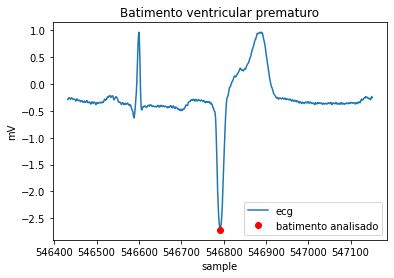

In [12]:
import matplotlib.pyplot as plt

p_signal, atr_sym, atr_sample = load_ecg("/content/drive/My Drive/mit-bih-arrhythmia-database-1.0.0/100")
abnormal = ['V', 'A','N']
ant = pd.DataFrame({'atr_sym':atr_sym,'atr_sample': atr_sample})

sampleA = []
sampleV = []
sampleN= []
for id, sym, sample in ant.itertuples():
  if sym == 'N':
    sampleN.append(sample)
  elif sym == 'A':
    sampleA.append(sample)
  elif sym == 'V':
    sampleV.append(sample)

#Print do batimento com PVC
ecg = p_signal[:,0]

x = np.arange(len(ecg))

inicio = sampleV[0] - 360
fim = sampleV[0] + 360



amostra = ecg[inicio:fim]

plt.plot(x[inicio:fim],ecg[inicio:fim],'-',label='ecg')
plt.plot(x[sampleV[0]],ecg[sampleV[0]],'ro',label='batimento analisado')
plt.title('Batimento ventricular prematuro')
plt.ylabel('mV')
plt.xlabel('sample')
plt.legend(loc='lower right')

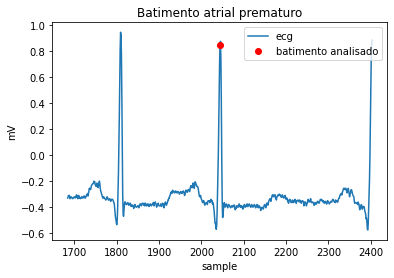

In [9]:
#Print do batimento com PAC
ecg = p_signal[:,0]

x = np.arange(len(ecg))

inicio = sampleA[0] - 360
fim = sampleA[0] + 360



amostra = ecg[inicio:fim]

plt.plot(x[inicio:fim],ecg[inicio:fim],'-',label='ecg')
plt.plot(x[sampleA[0]],ecg[sampleA[0]],'ro',label='batimento analisado')
plt.title('Batimento atrial prematuro')
plt.ylabel('mV')
plt.xlabel('sample')
plt.legend(loc='upper right')

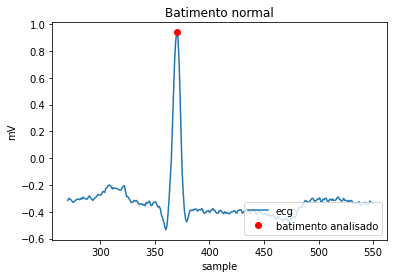

In [10]:
#Print do batimento normal
ecg = p_signal[:,0]

x = np.arange(len(ecg))

inicio = sampleN[1] - 100
fim = sampleN[1] + 180



amostra = ecg[inicio:fim]

plt.plot(x[inicio:fim],ecg[inicio:fim],'-',label='ecg')
plt.plot(x[sampleN[1]],ecg[sampleN[1]],'ro',label='batimento analisado')
plt.title('Batimento normal')
plt.ylabel('mV')
plt.xlabel('sample')
plt.legend(loc='lower right')

In [11]:
# Caminho onde os arquivos da base de dados estão armazenados
path = "/content/drive/My Drive/mit-bih-arrhythmia-database-1.0.0/"

# Cria um dataframe com os nomes dos arquivos
rec = pd.read_csv(path + "RECORDS", names=["n"], dtype=str)

# Lista de nonbeats e abnormal
nonbeat = ['[', '!', ']', 'x', '(', ')', 'p', 't', '`', 'u', '\\', '^', '|', '~', '+', 's', 'T', '*', 'D', '=', '"', '@', 'Q', '?']
abnormal = {'V', 'A'}

num_sec = 1
fs = 360
paciente_both = []
paciente_any = []
paciente_vpc = []
paciente_apc = []


for pt in rec.n:
  file = path + pt
  # Leitura e armazenamento das anotações
  annotation = wfdb.rdann(file, "atr")
  #Extrai os símbolos e anotações
  atr_sym = annotation.symbol
  atr_sample = annotation.sample

  atr_sym_set = set(atr_sym)

  if atr_sym_set.issuperset(abnormal):
    paciente_both.append(pt)

  if atr_sym_set.intersection(abnormal):
    paciente_any.append(pt)

  abnormal = list(abnormal)

  if abnormal[0] in atr_sym_set:
    paciente_vpc.append(pt)

  if abnormal[1] in atr_sym_set:
    paciente_apc.append(pt)

print("Número de pacientes com as duas arritmias: {}".format(len(paciente_both)))
print("Pacientes com as duas arritmias: {}".format(paciente_both))
print("Número de pacientes com pelo menos uma das arritmias: {}".format(len(paciente_any)))
print("Pacientes com pelo menos uma das arritmias: {}".format(paciente_any))
print("Número de pacientes com VPC: {}".format(len(paciente_vpc)))
print("Pacientes com VPC: {}".format(paciente_vpc))
print("Número de pacientes com APC: {}".format(len(paciente_apc)))
print("Pacientes com APC: {}".format(paciente_apc))

Número de pacientes com as duas arritmias: 20
Pacientes com as duas arritmias: ['100', '108', '114', '116', '118', '121', '124', '200', '201', '202', '205', '207', '209', '213', '215', '219', '223', '228', '231', '233']
Número de pacientes com pelo menos uma das arritmias: 44
Pacientes com pelo menos uma das arritmias: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '114', '116', '117', '118', '119', '121', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
Número de pacientes com VPC: 37
Pacientes com VPC: ['100', '102', '104', '105', '106', '107', '108', '109', '111', '114', '116', '118', '119', '121', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '213', '214', '215', '217', '219', '221', '223', '228', '230', '231', '233', '234']
Número de pacientes com APC: 27
Pacientes com APC: ['100', 